In [83]:
import os
import math
import torch
print('Torch Version: ', torch.__version__)

Torch Version:  2.1.0+cu118


In [84]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html


In [85]:
from torch_geometric.data import Data
from torch_geometric.datasets import Twitch
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

In [86]:
num_nodes = { 'DE': 9498, 'EN' : 7126, 'ES' : 4648, 'FR' : 6551, 'PT' : 1912, 'RU' : 4385}
val_sizes = {}
test_sizes = {}
for name in num_nodes.keys():
  val_sizes[name] = math.floor(num_nodes[name] * 0.05)
  test_sizes[name] = math.floor(num_nodes[name] * 0.2)


In [87]:
dataset_names = ['DE', 'EN', 'ES', 'FR', 'PT', 'RU']
datasets = {}
for dataset_name in dataset_names:
  val_size = val_sizes[dataset_name]
  test_size = test_sizes[dataset_name]
  transform = T.Compose([T.RandomNodeSplit(num_val=val_size, num_test=test_size),])
  datasets[dataset_name] = Twitch('/tmp/{}'.format(dataset_name), dataset_name, transform=transform)

In [88]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()

    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)
    self.act = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(p=0.5)

  def forward(self, node_feature, edge_index):
    out = self.conv1(node_feature, edge_index)
    out = self.act(out)
    out = self.drop(out)
    out = self.conv2(out, edge_index)
    out = self.drop(out)

    return out


In [89]:
def train(model, data, optimizer, loss_fn):

    loss = 0

    model.train()
    optimizer.zero_grad()

    output = model(data.x, data.edge_index)
    loss = loss_fn(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss

In [90]:
@torch.no_grad()
def test(model, data):

    accuracy_list = [0, 0, 0]

    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)

    for i, mask in enumerate([data.train_mask, data.val_mask, data.test_mask]):
      correct = pred[mask].eq(data.y[mask]).sum().item()
      total = mask.sum().item()
      accuracy_list[i] = correct / total if total != 0 else 0

    return accuracy_list

In [91]:
hidden_channels = 32
num_features = datasets['EN'].num_features
num_classes = len(datasets['EN'][0].y.unique())

print(num_features, num_classes)

128 2


In [92]:
def run_trial(dataset_name, lr=0.01, weight_decay=1e-3, epochs=200, window_size=10):
  model = GCN(num_features, hidden_channels=hidden_channels, out_channels=num_classes)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = torch.nn.CrossEntropyLoss()

  data = datasets[dataset_name][0]

  train_curve = []
  val_curve = []
  test_curve = []

  prev_val_acc = 0
  best_val_acc = final_test_acc = window_count = 0
  for epoch in range(1, epochs + 1):
      loss = train(model, data, optimizer, loss_fn)
      # print(loss)
      train_acc, val_acc, test_acc = test(model, data)
      # print(train_acc, val_acc, test_acc)
      window_count = (window_count + 1) if val_acc < prev_val_acc else 0

      train_curve.append(loss.detach().numpy())
      val_curve.append(val_acc)
      test_curve.append(test_acc)

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc

      if window_count >= window_size:
        break
      prev_val_acc = val_acc

      print(f'Epoch: {epoch:03d}, Test Acc: {test_acc:.4f}')
  print()
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))

  results = { dataset_name : test_acc}
  for name in dataset_names:
    if name == dataset_name:
      continue

    _, _, test_acc = test(model, datasets[name][0])
    # print(name, test_acc)
    results[name] = test_acc
  return results, model, (train_curve, val_curve, test_curve)

In [93]:
from scipy.stats import sem
import matplotlib.pyplot as plt

In [94]:
num_trials = 3

def run_trials(dataset_name, num_trials, lr=0.01, weight_decay=1e-3, epochs=200, window_size=10):
  results = dict((name, []) for name in dataset_names)
  model = None
  curves = None
  for i in range(num_trials):
    result, model, curves = run_trial(dataset_name, lr, weight_decay, epochs, window_size)
    for name in dataset_names:
      results[name].append(result[name])
  return results, model, curves

In [95]:
def show_results(dataset_name, results):
  hist_means = []
  se_points = []

  print('Training on {},'.format(dataset_name))
  for name in dataset_names:
    mean = sum(results[name])/len(results[name])
    se = sem(results[name])
    hist_means.append(mean)
    se_points.append(se)

    if name == dataset_name:
      print('with in of distribution testing on {}: mean {}, SE {}'.format(name, mean, se))
      continue
    print('with out of distribution testing on {}: mean {}, SE {}'.format(name, mean, se))

  hist_means.pop(dataset_names.index(dataset_name))
  se_points.pop(dataset_names.index(dataset_name))
  masked_dataset_names = dataset_names.copy()
  masked_dataset_names.remove(dataset_name)

  plt.bar(masked_dataset_names, hist_means)
  plt.errorbar(masked_dataset_names, hist_means, se_points, fmt="o", color="r")
  plt.title('Out of Distribution Accuracy with Training on {}'.format(dataset_name))
  plt.show


In [96]:
def plot_curves(curves, dataset_name):
    epochs = range(1, len(curves[0]) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves[0], label='Training Loss')
    plt.title('Training Loss over Epochs on {}'.format(dataset_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, curves[1], label='Validation Acc', color='orange')
    plt.plot(epochs, curves[2], label='Test Acc', color='green')
    plt.title('In Distribution Validation and Test Acc over Epochs on {}'.format(dataset_name))
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Experiments

In [97]:
en_res, en_model, en_curves = run_trials('EN', num_trials)

Epoch: 001, Test Acc: 0.5439
Epoch: 002, Test Acc: 0.5747
Epoch: 003, Test Acc: 0.5804
Epoch: 004, Test Acc: 0.5986
Epoch: 005, Test Acc: 0.6000
Epoch: 006, Test Acc: 0.5972
Epoch: 007, Test Acc: 0.6000
Epoch: 008, Test Acc: 0.5979
Epoch: 009, Test Acc: 0.5993
Epoch: 010, Test Acc: 0.6021
Epoch: 011, Test Acc: 0.6028
Epoch: 012, Test Acc: 0.6091
Epoch: 013, Test Acc: 0.6119
Epoch: 014, Test Acc: 0.6147
Epoch: 015, Test Acc: 0.6105
Epoch: 016, Test Acc: 0.6091
Epoch: 017, Test Acc: 0.6077
Epoch: 018, Test Acc: 0.6091
Epoch: 019, Test Acc: 0.6119
Epoch: 020, Test Acc: 0.6119
Epoch: 021, Test Acc: 0.6126
Epoch: 022, Test Acc: 0.6112
Epoch: 023, Test Acc: 0.6126
Epoch: 024, Test Acc: 0.6126
Epoch: 025, Test Acc: 0.6133
Epoch: 026, Test Acc: 0.6105
Epoch: 027, Test Acc: 0.6098
Epoch: 028, Test Acc: 0.6077
Epoch: 029, Test Acc: 0.6070
Epoch: 030, Test Acc: 0.6091
Epoch: 031, Test Acc: 0.6056
Epoch: 032, Test Acc: 0.6049
Epoch: 033, Test Acc: 0.6042
Epoch: 034, Test Acc: 0.6035
Epoch: 035, Te

Training on EN,
with out of distribution testing on DE: mean 0.6127786554326838, SE 0.01953684265820822
with in of distribution testing on EN: mean 0.6023391812865496, SE 0.0009356725146198638
with out of distribution testing on ES: mean 0.6261212773591676, SE 0.0198904363854111
with out of distribution testing on FR: mean 0.5368956743002544, SE 0.05533049479870192
with out of distribution testing on PT: mean 0.5445026178010471, SE 0.057133670278781336
with out of distribution testing on RU: mean 0.6362599771949828, SE 0.006033640390113113


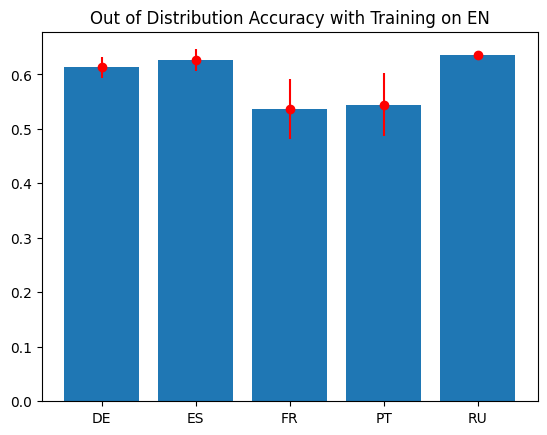

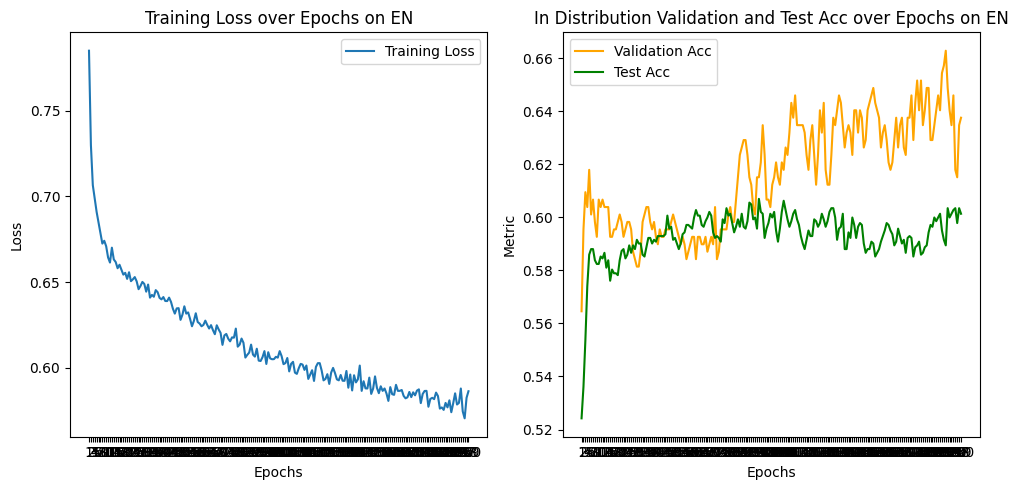

In [98]:
show_results('EN', en_res)
plot_curves(en_curves, 'EN')

In [99]:
de_res, de_model, de_curves = run_trials('DE', num_trials)

Epoch: 001, Test Acc: 0.6293
Epoch: 002, Test Acc: 0.6524
Epoch: 003, Test Acc: 0.6572
Epoch: 004, Test Acc: 0.6756
Epoch: 005, Test Acc: 0.6804
Epoch: 006, Test Acc: 0.6835
Epoch: 007, Test Acc: 0.6830
Epoch: 008, Test Acc: 0.6830
Epoch: 009, Test Acc: 0.6872
Epoch: 010, Test Acc: 0.6883
Epoch: 011, Test Acc: 0.6872
Epoch: 012, Test Acc: 0.6877
Epoch: 013, Test Acc: 0.6893
Epoch: 014, Test Acc: 0.6867
Epoch: 015, Test Acc: 0.6862
Epoch: 016, Test Acc: 0.6862
Epoch: 017, Test Acc: 0.6814
Epoch: 018, Test Acc: 0.6862
Epoch: 019, Test Acc: 0.6862
Epoch: 020, Test Acc: 0.6898
Epoch: 021, Test Acc: 0.6930
Epoch: 022, Test Acc: 0.6898
Epoch: 023, Test Acc: 0.6862
Epoch: 024, Test Acc: 0.6851
Epoch: 025, Test Acc: 0.6888
Epoch: 026, Test Acc: 0.6930
Epoch: 027, Test Acc: 0.6925
Epoch: 028, Test Acc: 0.6946
Epoch: 029, Test Acc: 0.6951
Epoch: 030, Test Acc: 0.6914
Epoch: 031, Test Acc: 0.6862
Epoch: 032, Test Acc: 0.6862
Epoch: 033, Test Acc: 0.6925
Epoch: 034, Test Acc: 0.6935
Epoch: 035, Te

Training on DE,
with in of distribution testing on DE: mean 0.6793048973143759, SE 0.002597621307170223
with out of distribution testing on EN: mean 0.5571929824561405, SE 0.008193815152344809
with out of distribution testing on ES: mean 0.6713311804808039, SE 0.009832931184818622
with out of distribution testing on FR: mean 0.43104325699745544, SE 0.010139877274896335
with out of distribution testing on PT: mean 0.6335078534031413, SE 0.01317597632682505
with out of distribution testing on RU: mean 0.5537818320030407, SE 0.041959234607298806


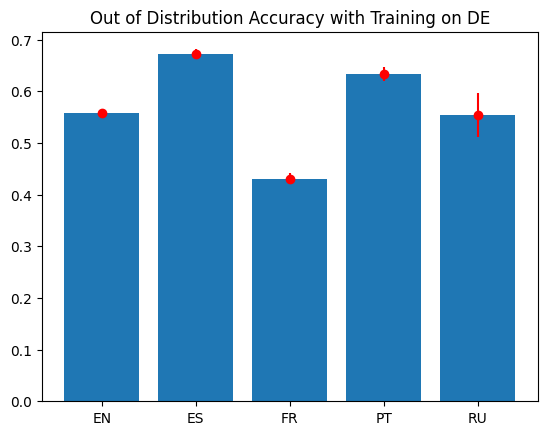

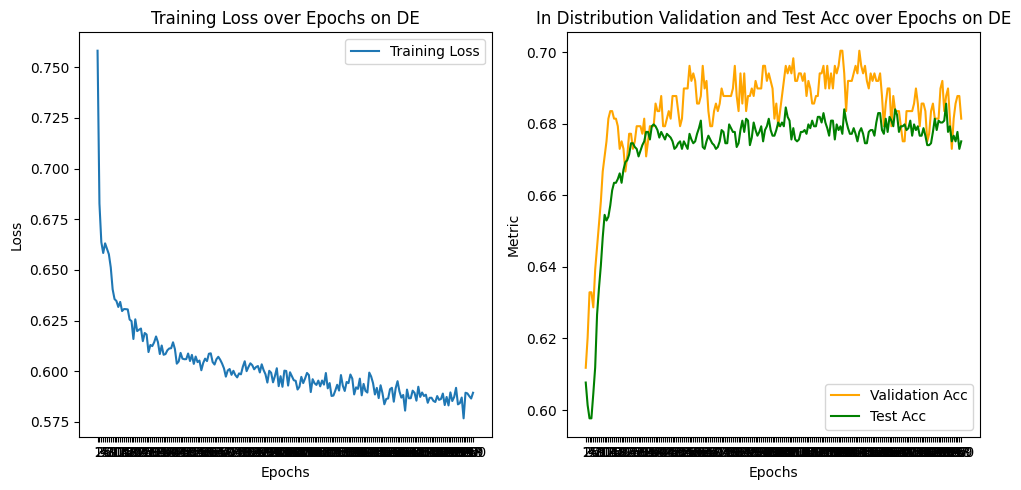

In [100]:
show_results('DE', de_res)
plot_curves(de_curves, 'DE')

In [101]:
es_res, es_model, es_curves = run_trials('ES', num_trials)

Epoch: 001, Test Acc: 0.6136
Epoch: 002, Test Acc: 0.6771
Epoch: 003, Test Acc: 0.6986
Epoch: 004, Test Acc: 0.7051
Epoch: 005, Test Acc: 0.7094
Epoch: 006, Test Acc: 0.7104
Epoch: 007, Test Acc: 0.7147
Epoch: 008, Test Acc: 0.7180
Epoch: 009, Test Acc: 0.7287
Epoch: 010, Test Acc: 0.7266
Epoch: 011, Test Acc: 0.7169
Epoch: 012, Test Acc: 0.7201
Epoch: 013, Test Acc: 0.7147
Epoch: 014, Test Acc: 0.7191
Epoch: 015, Test Acc: 0.7191
Epoch: 016, Test Acc: 0.7169
Epoch: 017, Test Acc: 0.7201
Epoch: 018, Test Acc: 0.7212
Epoch: 019, Test Acc: 0.7212
Epoch: 020, Test Acc: 0.7212
Epoch: 021, Test Acc: 0.7223
Epoch: 022, Test Acc: 0.7234
Epoch: 023, Test Acc: 0.7277
Epoch: 024, Test Acc: 0.7277
Epoch: 025, Test Acc: 0.7266
Epoch: 026, Test Acc: 0.7277
Epoch: 027, Test Acc: 0.7277
Epoch: 028, Test Acc: 0.7277
Epoch: 029, Test Acc: 0.7266
Epoch: 030, Test Acc: 0.7255
Epoch: 031, Test Acc: 0.7287
Epoch: 032, Test Acc: 0.7277
Epoch: 033, Test Acc: 0.7320
Epoch: 034, Test Acc: 0.7320
Epoch: 035, Te

Training on ES,
with out of distribution testing on DE: mean 0.6368263998595752, SE 0.006915118695310603
with out of distribution testing on EN: mean 0.4783625730994152, SE 0.004695873660791754
with in of distribution testing on ES: mean 0.7463222102619304, SE 0.01274150046972709
with out of distribution testing on FR: mean 0.5798982188295166, SE 0.03602733557773523
with out of distribution testing on PT: mean 0.6780104712041884, SE 0.013602493253158722
with out of distribution testing on RU: mean 0.733561383504371, SE 0.008938028138582176


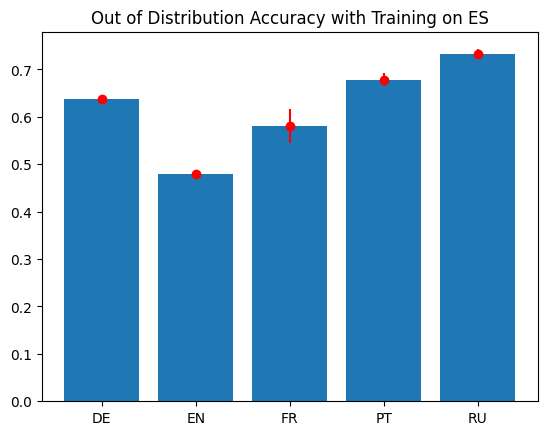

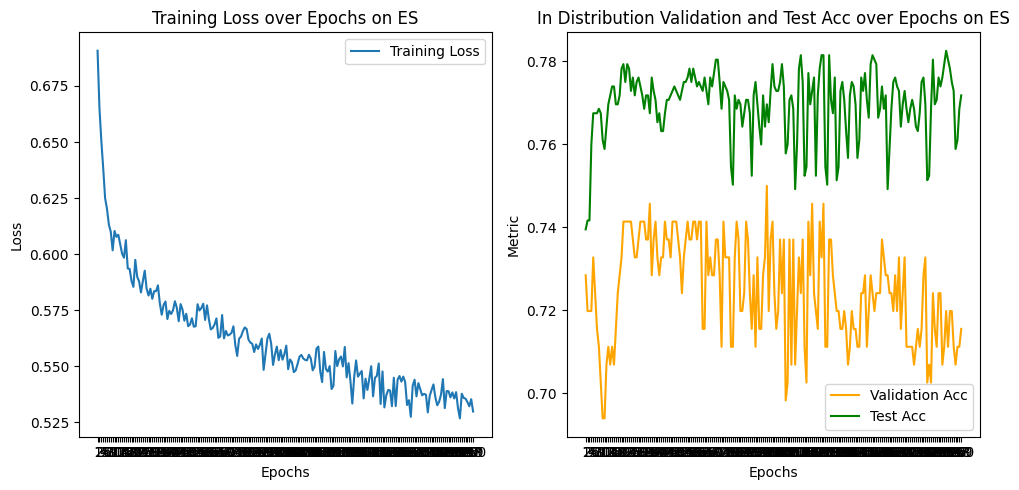

In [102]:
show_results('ES', es_res)
plot_curves(es_curves, 'ES')

In [103]:
fr_res, fr_model, fr_curves = run_trials('FR', num_trials)

Epoch: 001, Test Acc: 0.5817
Epoch: 002, Test Acc: 0.6153
Epoch: 003, Test Acc: 0.6198
Epoch: 004, Test Acc: 0.6198
Epoch: 005, Test Acc: 0.6214
Epoch: 006, Test Acc: 0.6221
Epoch: 007, Test Acc: 0.6198
Epoch: 008, Test Acc: 0.6183
Epoch: 009, Test Acc: 0.6176
Epoch: 010, Test Acc: 0.6176
Epoch: 011, Test Acc: 0.6168
Epoch: 012, Test Acc: 0.6145
Epoch: 013, Test Acc: 0.6168
Epoch: 014, Test Acc: 0.6160
Epoch: 015, Test Acc: 0.6176
Epoch: 016, Test Acc: 0.6168
Epoch: 017, Test Acc: 0.6183
Epoch: 018, Test Acc: 0.6191
Epoch: 019, Test Acc: 0.6183
Epoch: 020, Test Acc: 0.6183
Epoch: 021, Test Acc: 0.6183
Epoch: 022, Test Acc: 0.6176
Epoch: 023, Test Acc: 0.6176
Epoch: 024, Test Acc: 0.6176
Epoch: 025, Test Acc: 0.6176
Epoch: 026, Test Acc: 0.6176
Epoch: 027, Test Acc: 0.6176
Epoch: 028, Test Acc: 0.6168
Epoch: 029, Test Acc: 0.6183
Epoch: 030, Test Acc: 0.6176
Epoch: 031, Test Acc: 0.6176
Epoch: 032, Test Acc: 0.6168
Epoch: 033, Test Acc: 0.6160
Epoch: 034, Test Acc: 0.6160
Epoch: 035, Te

Training on FR,
with out of distribution testing on DE: mean 0.5615236089169738, SE 0.04169664473591022
with out of distribution testing on EN: mean 0.5221052631578947, SE 0.02892556329196484
with out of distribution testing on ES: mean 0.6914244707570866, SE 0.020256017475812637
with in of distribution testing on FR: mean 0.6206106870229008, SE 0.013044280527202355
with out of distribution testing on PT: mean 0.599476439790576, SE 0.04685303231643559
with out of distribution testing on RU: mean 0.5032307107563664, SE 0.0568196407172143


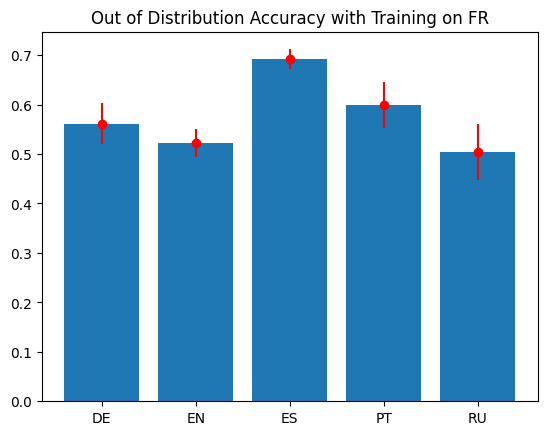

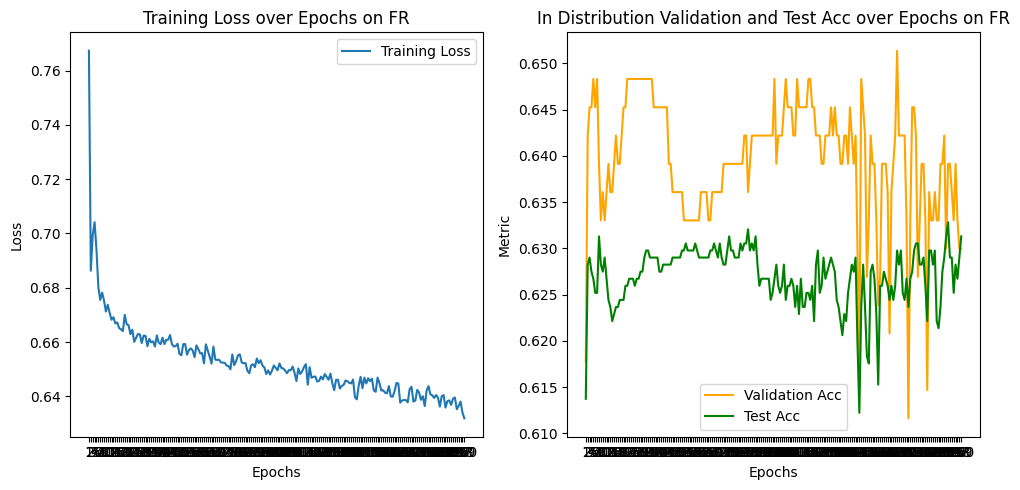

In [104]:
show_results('FR', fr_res)
plot_curves(fr_curves, 'FR')

In [122]:
pt_res, pt_model, pt_curves = run_trials('PT', num_trials)

Epoch: 001, Test Acc: 0.6361
Epoch: 002, Test Acc: 0.6492
Epoch: 003, Test Acc: 0.6492
Epoch: 004, Test Acc: 0.6518
Epoch: 005, Test Acc: 0.6518
Epoch: 006, Test Acc: 0.6780
Epoch: 007, Test Acc: 0.6937
Epoch: 008, Test Acc: 0.7016
Epoch: 009, Test Acc: 0.7042
Epoch: 010, Test Acc: 0.7068
Epoch: 011, Test Acc: 0.6990
Epoch: 012, Test Acc: 0.7016
Epoch: 013, Test Acc: 0.6937
Epoch: 014, Test Acc: 0.6911
Epoch: 015, Test Acc: 0.6963
Epoch: 016, Test Acc: 0.6963
Epoch: 017, Test Acc: 0.6963
Epoch: 018, Test Acc: 0.7094
Epoch: 019, Test Acc: 0.7094
Epoch: 020, Test Acc: 0.7199
Epoch: 021, Test Acc: 0.7173
Epoch: 022, Test Acc: 0.7120
Epoch: 023, Test Acc: 0.7173
Epoch: 024, Test Acc: 0.7147
Epoch: 025, Test Acc: 0.7042
Epoch: 026, Test Acc: 0.7042
Epoch: 027, Test Acc: 0.7068
Epoch: 028, Test Acc: 0.7120
Epoch: 029, Test Acc: 0.7120
Epoch: 030, Test Acc: 0.7173
Epoch: 031, Test Acc: 0.7173
Epoch: 032, Test Acc: 0.7225
Epoch: 033, Test Acc: 0.7173
Epoch: 034, Test Acc: 0.7225
Epoch: 035, Te

Training on PT,
with out of distribution testing on DE: mean 0.5725820607337195, SE 0.00896927245289886
with out of distribution testing on EN: mean 0.47555555555555556, SE 0.012490001472947362
with out of distribution testing on ES: mean 0.6792249730893434, SE 0.0032885365589923688
with out of distribution testing on FR: mean 0.629262086513995, SE 0.002427326212256859
with in of distribution testing on PT: mean 0.6893542757417103, SE 0.017452006980802813
with out of distribution testing on RU: mean 0.7001140250855188, SE 0.010262257696693273


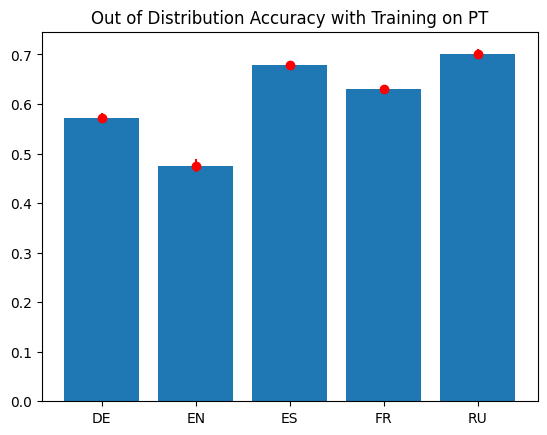

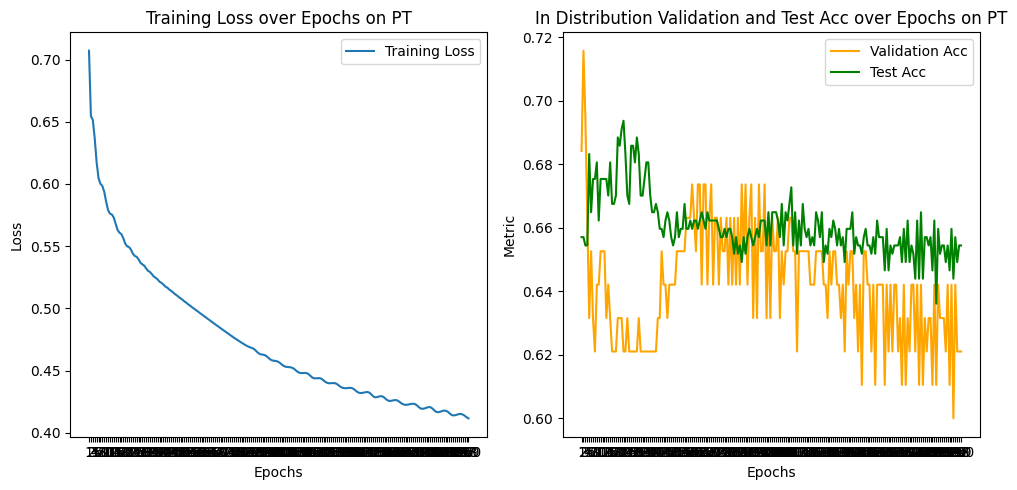

In [123]:
show_results('PT', pt_res)
plot_curves(pt_curves, 'PT')

In [107]:
ru_res, ru_model, ru_curves = run_trials('RU', num_trials)

Epoch: 001, Test Acc: 0.6648
Epoch: 002, Test Acc: 0.7343
Epoch: 003, Test Acc: 0.7560
Epoch: 004, Test Acc: 0.7594
Epoch: 005, Test Acc: 0.7617
Epoch: 006, Test Acc: 0.7651
Epoch: 007, Test Acc: 0.7674
Epoch: 008, Test Acc: 0.7674
Epoch: 009, Test Acc: 0.7697
Epoch: 010, Test Acc: 0.7708
Epoch: 011, Test Acc: 0.7708
Epoch: 012, Test Acc: 0.7719
Epoch: 013, Test Acc: 0.7685
Epoch: 014, Test Acc: 0.7685
Epoch: 015, Test Acc: 0.7685
Epoch: 016, Test Acc: 0.7697
Epoch: 017, Test Acc: 0.7719
Epoch: 018, Test Acc: 0.7719
Epoch: 019, Test Acc: 0.7708
Epoch: 020, Test Acc: 0.7719
Epoch: 021, Test Acc: 0.7719
Epoch: 022, Test Acc: 0.7719
Epoch: 023, Test Acc: 0.7719
Epoch: 024, Test Acc: 0.7708
Epoch: 025, Test Acc: 0.7708
Epoch: 026, Test Acc: 0.7697
Epoch: 027, Test Acc: 0.7697
Epoch: 028, Test Acc: 0.7697
Epoch: 029, Test Acc: 0.7697
Epoch: 030, Test Acc: 0.7697
Epoch: 031, Test Acc: 0.7697
Epoch: 032, Test Acc: 0.7685
Epoch: 033, Test Acc: 0.7685
Epoch: 034, Test Acc: 0.7674
Epoch: 035, Te

Training on RU,
with out of distribution testing on DE: mean 0.45655608214849924, SE 0.006886096277315446
with out of distribution testing on EN: mean 0.46362573099415205, SE 0.006686131428283718
with out of distribution testing on ES: mean 0.710800143523502, SE 0.010948077719693104
with out of distribution testing on FR: mean 0.6165394402035623, SE 0.005439582271356711
with out of distribution testing on PT: mean 0.6369982547993018, SE 0.01221640488656197
with in of distribution testing on RU: mean 0.7404028886354999, SE 0.006256966033125943


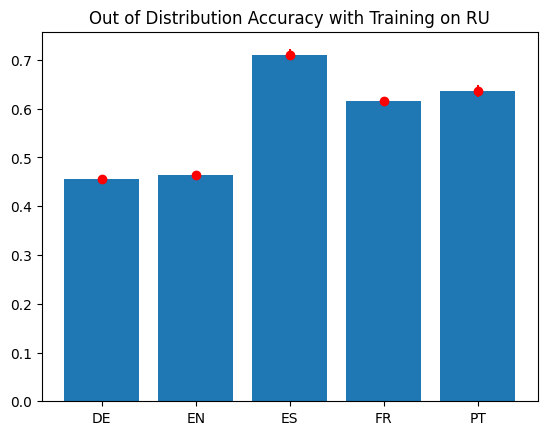

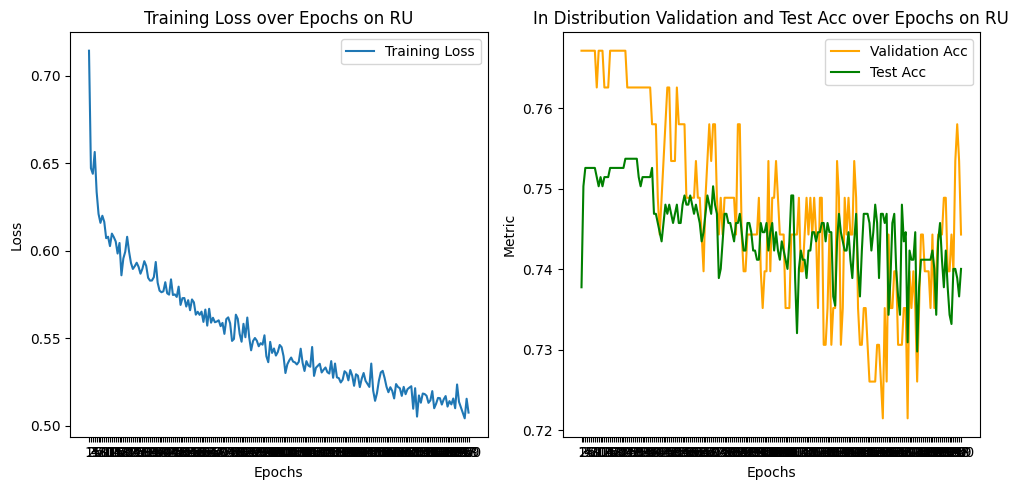

In [108]:
show_results('RU', ru_res)
plot_curves(ru_curves, 'RU')

## Ablation analysis without drop layer

In [109]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()

    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)
    self.act = torch.nn.ReLU()

  def forward(self, node_feature, edge_index):
    out = self.conv1(node_feature, edge_index)
    out = self.act(out)
    out = self.conv2(out, edge_index)

    return out


In [110]:
ab_en_res, ab_en_model, ab_en_curves = run_trials('EN', num_trials)

Epoch: 001, Test Acc: 0.5733
Epoch: 002, Test Acc: 0.6021
Epoch: 003, Test Acc: 0.5958
Epoch: 004, Test Acc: 0.6028
Epoch: 005, Test Acc: 0.6035
Epoch: 006, Test Acc: 0.6091
Epoch: 007, Test Acc: 0.6063
Epoch: 008, Test Acc: 0.6105
Epoch: 009, Test Acc: 0.6126
Epoch: 010, Test Acc: 0.6175
Epoch: 011, Test Acc: 0.6182
Epoch: 012, Test Acc: 0.6147
Epoch: 013, Test Acc: 0.6196
Epoch: 014, Test Acc: 0.6154
Epoch: 015, Test Acc: 0.6084
Epoch: 016, Test Acc: 0.6126
Epoch: 017, Test Acc: 0.6154
Epoch: 018, Test Acc: 0.6119
Epoch: 019, Test Acc: 0.6112
Epoch: 020, Test Acc: 0.6077
Epoch: 021, Test Acc: 0.6133
Epoch: 022, Test Acc: 0.6140
Epoch: 023, Test Acc: 0.6147
Epoch: 024, Test Acc: 0.6140
Epoch: 025, Test Acc: 0.6126
Epoch: 026, Test Acc: 0.6126
Epoch: 027, Test Acc: 0.6119
Epoch: 028, Test Acc: 0.6140
Epoch: 029, Test Acc: 0.6091
Epoch: 030, Test Acc: 0.6105
Epoch: 031, Test Acc: 0.6091
Epoch: 032, Test Acc: 0.6112
Epoch: 033, Test Acc: 0.6084
Epoch: 034, Test Acc: 0.6077
Epoch: 035, Te

Training on EN,
with out of distribution testing on DE: mean 0.5051781639459364, SE 0.030839549572610224
with in of distribution testing on EN: mean 0.5864327485380117, SE 0.00046783625730991335
with out of distribution testing on ES: mean 0.5748116254036599, SE 0.039555308884707006
with out of distribution testing on FR: mean 0.5272264631043257, SE 0.034142235354136394
with out of distribution testing on PT: mean 0.5401396160558464, SE 0.03584040624417601
with out of distribution testing on RU: mean 0.5815279361459521, SE 0.03874057167096054


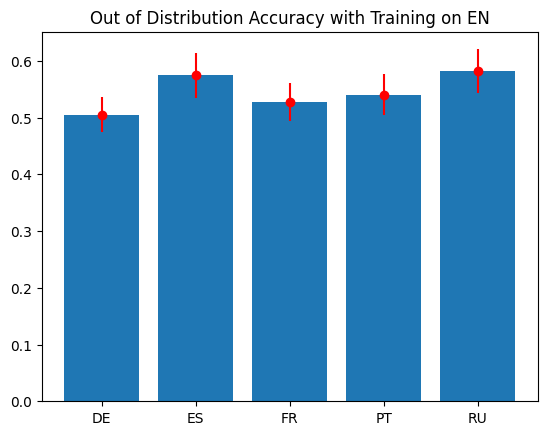

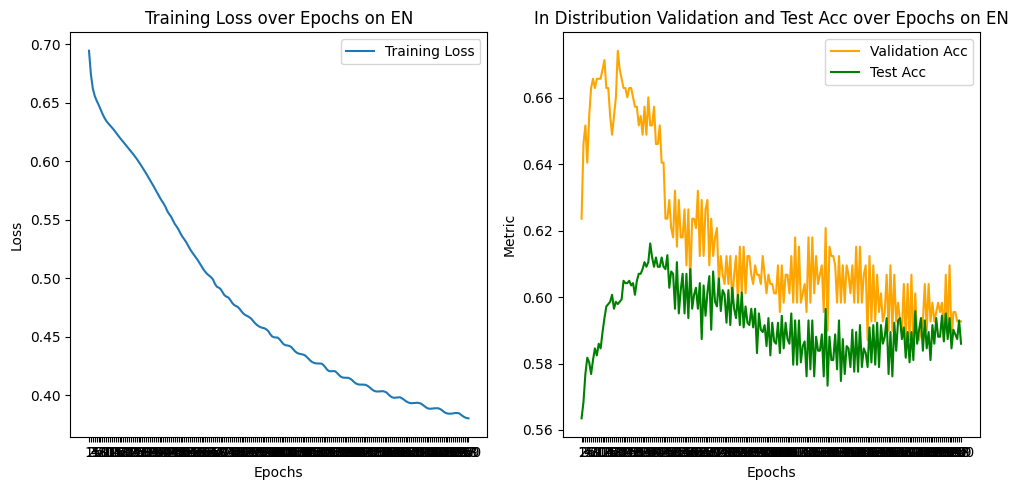

In [111]:
show_results('EN', ab_en_res)
plot_curves(ab_en_curves, 'EN')

In [112]:
ab_de_res, ab_de_model, ab_de_curves = run_trials('DE', num_trials)

Epoch: 001, Test Acc: 0.6061
Epoch: 002, Test Acc: 0.6103
Epoch: 003, Test Acc: 0.6130
Epoch: 004, Test Acc: 0.6187
Epoch: 005, Test Acc: 0.6256
Epoch: 006, Test Acc: 0.6324
Epoch: 007, Test Acc: 0.6424
Epoch: 008, Test Acc: 0.6509
Epoch: 009, Test Acc: 0.6556
Epoch: 010, Test Acc: 0.6577
Epoch: 011, Test Acc: 0.6577
Epoch: 012, Test Acc: 0.6577
Epoch: 013, Test Acc: 0.6588
Epoch: 014, Test Acc: 0.6619
Epoch: 015, Test Acc: 0.6656
Epoch: 016, Test Acc: 0.6698
Epoch: 017, Test Acc: 0.6709
Epoch: 018, Test Acc: 0.6704
Epoch: 019, Test Acc: 0.6704
Epoch: 020, Test Acc: 0.6719
Epoch: 021, Test Acc: 0.6693
Epoch: 022, Test Acc: 0.6698
Epoch: 023, Test Acc: 0.6714
Epoch: 024, Test Acc: 0.6709
Epoch: 025, Test Acc: 0.6719
Epoch: 026, Test Acc: 0.6714
Epoch: 027, Test Acc: 0.6709
Epoch: 028, Test Acc: 0.6714
Epoch: 029, Test Acc: 0.6730
Epoch: 030, Test Acc: 0.6730
Epoch: 031, Test Acc: 0.6725
Epoch: 032, Test Acc: 0.6725
Epoch: 033, Test Acc: 0.6735
Epoch: 034, Test Acc: 0.6735
Epoch: 035, Te

Training on DE,
with in of distribution testing on DE: mean 0.6831665789011762, SE 0.0052863683855978935
with out of distribution testing on EN: mean 0.5366081871345029, SE 0.00697452702497101
with out of distribution testing on ES: mean 0.6785073555794762, SE 0.008345678758244006
with out of distribution testing on FR: mean 0.46488549618320607, SE 0.025785260693213036
with out of distribution testing on PT: mean 0.6492146596858639, SE 0.013602493253158722
with out of distribution testing on RU: mean 0.5416191562143671, SE 0.028031005803865135


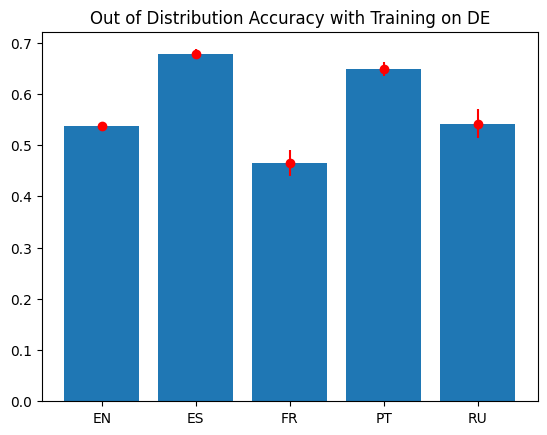

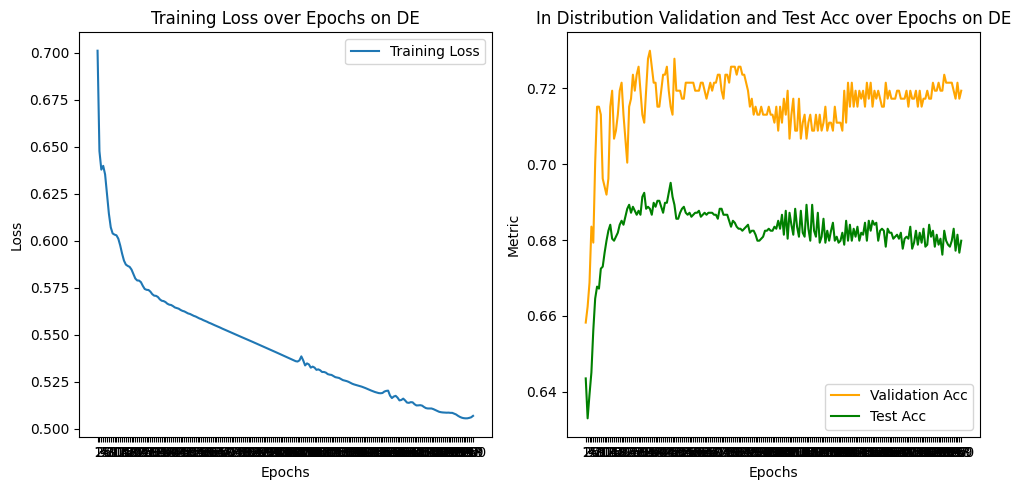

In [113]:
show_results('DE', ab_de_res)
plot_curves(ab_de_curves, 'DE')

In [114]:
ab_es_res, ab_es_model, ab_es_curves = run_trials('ES', num_trials)

Epoch: 001, Test Acc: 0.6265
Epoch: 002, Test Acc: 0.6738
Epoch: 003, Test Acc: 0.6814
Epoch: 004, Test Acc: 0.6878
Epoch: 005, Test Acc: 0.6868
Epoch: 006, Test Acc: 0.6846
Epoch: 007, Test Acc: 0.6878
Epoch: 008, Test Acc: 0.6878
Epoch: 009, Test Acc: 0.6954
Epoch: 010, Test Acc: 0.7008
Epoch: 011, Test Acc: 0.7104
Epoch: 012, Test Acc: 0.7212
Epoch: 013, Test Acc: 0.7169
Epoch: 014, Test Acc: 0.7212
Epoch: 015, Test Acc: 0.7180
Epoch: 016, Test Acc: 0.7191
Epoch: 017, Test Acc: 0.7201
Epoch: 018, Test Acc: 0.7255
Epoch: 019, Test Acc: 0.7234
Epoch: 020, Test Acc: 0.7223
Epoch: 021, Test Acc: 0.7223
Epoch: 022, Test Acc: 0.7147
Epoch: 023, Test Acc: 0.7191
Epoch: 024, Test Acc: 0.7180
Epoch: 025, Test Acc: 0.7201
Epoch: 026, Test Acc: 0.7212
Epoch: 027, Test Acc: 0.7244
Epoch: 028, Test Acc: 0.7223
Epoch: 029, Test Acc: 0.7169
Epoch: 030, Test Acc: 0.7137
Epoch: 031, Test Acc: 0.7158
Epoch: 032, Test Acc: 0.7169
Epoch: 033, Test Acc: 0.7180
Epoch: 034, Test Acc: 0.7158
Epoch: 035, Te

Training on ES,
with out of distribution testing on DE: mean 0.6410391434088116, SE 0.008781813411514135
with out of distribution testing on EN: mean 0.4654970760233918, SE 0.00544079688870784
with in of distribution testing on ES: mean 0.736275565123789, SE 0.01118654988742009
with out of distribution testing on FR: mean 0.5475826972010178, SE 0.013002021670270968
with out of distribution testing on PT: mean 0.6797556719022687, SE 0.031060160088233306
with out of distribution testing on RU: mean 0.6993538578487267, SE 0.014185828663262285


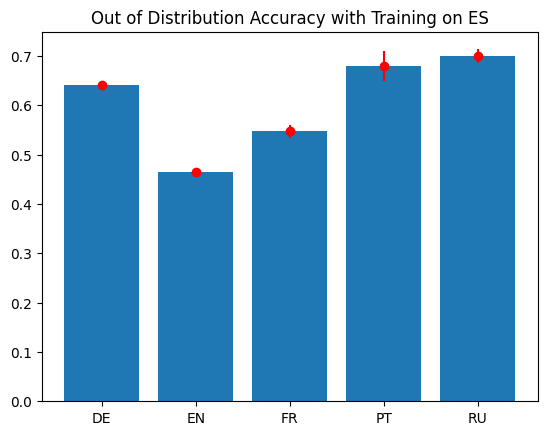

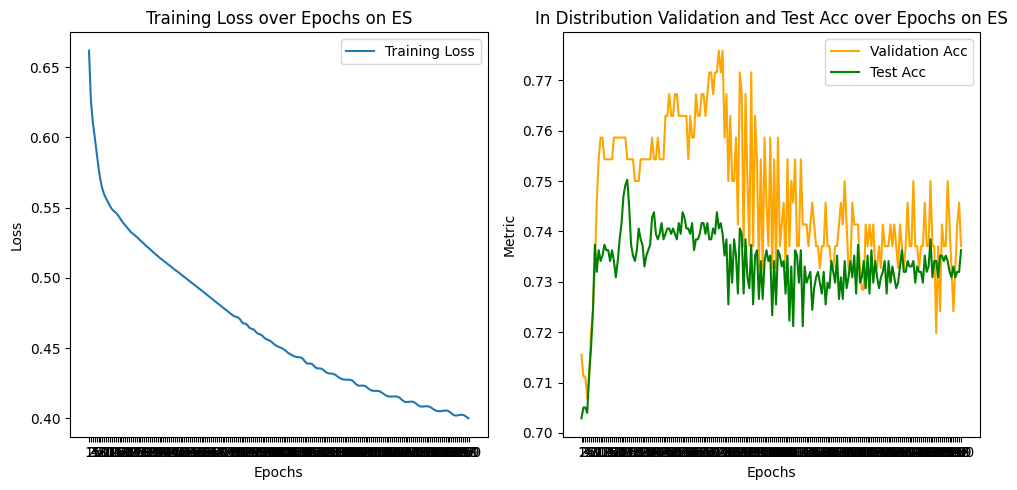

In [115]:
show_results('ES', ab_es_res)
plot_curves(ab_es_curves, 'ES')

In [116]:
ab_fr_res, ab_fr_model, ab_fr_curves = run_trials('FR', num_trials)

Epoch: 001, Test Acc: 0.6046
Epoch: 002, Test Acc: 0.6321
Epoch: 003, Test Acc: 0.6328
Epoch: 004, Test Acc: 0.6336
Epoch: 005, Test Acc: 0.6344
Epoch: 006, Test Acc: 0.6351
Epoch: 007, Test Acc: 0.6336
Epoch: 008, Test Acc: 0.6344
Epoch: 009, Test Acc: 0.6351
Epoch: 010, Test Acc: 0.6344
Epoch: 011, Test Acc: 0.6359
Epoch: 012, Test Acc: 0.6359
Epoch: 013, Test Acc: 0.6366
Epoch: 014, Test Acc: 0.6359
Epoch: 015, Test Acc: 0.6344
Epoch: 016, Test Acc: 0.6359
Epoch: 017, Test Acc: 0.6374
Epoch: 018, Test Acc: 0.6374
Epoch: 019, Test Acc: 0.6374
Epoch: 020, Test Acc: 0.6366
Epoch: 021, Test Acc: 0.6374
Epoch: 022, Test Acc: 0.6382
Epoch: 023, Test Acc: 0.6382
Epoch: 024, Test Acc: 0.6382
Epoch: 025, Test Acc: 0.6389
Epoch: 026, Test Acc: 0.6389
Epoch: 027, Test Acc: 0.6389
Epoch: 028, Test Acc: 0.6389
Epoch: 029, Test Acc: 0.6389
Epoch: 030, Test Acc: 0.6389
Epoch: 031, Test Acc: 0.6389
Epoch: 032, Test Acc: 0.6389
Epoch: 033, Test Acc: 0.6382
Epoch: 034, Test Acc: 0.6374
Epoch: 035, Te

Training on FR,
with out of distribution testing on DE: mean 0.6117254695453748, SE 0.02940183233122844
with out of distribution testing on EN: mean 0.5239766081871345, SE 0.012763015546857293
with out of distribution testing on ES: mean 0.6846071044133476, SE 0.02137548763345026
with in of distribution testing on FR: mean 0.6216284987277354, SE 0.006112169032806277
with out of distribution testing on PT: mean 0.6221640488656196, SE 0.040900668918875976
with out of distribution testing on RU: mean 0.47396427213987075, SE 0.048243676957633715


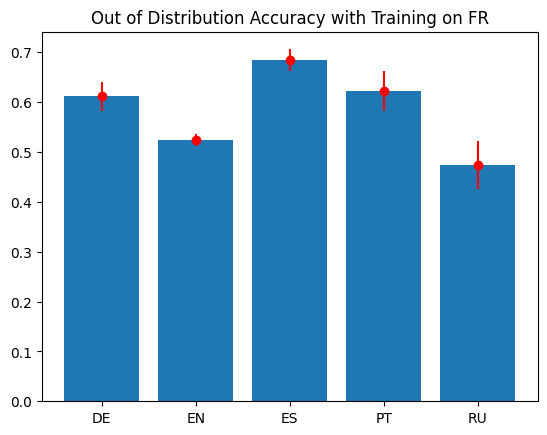

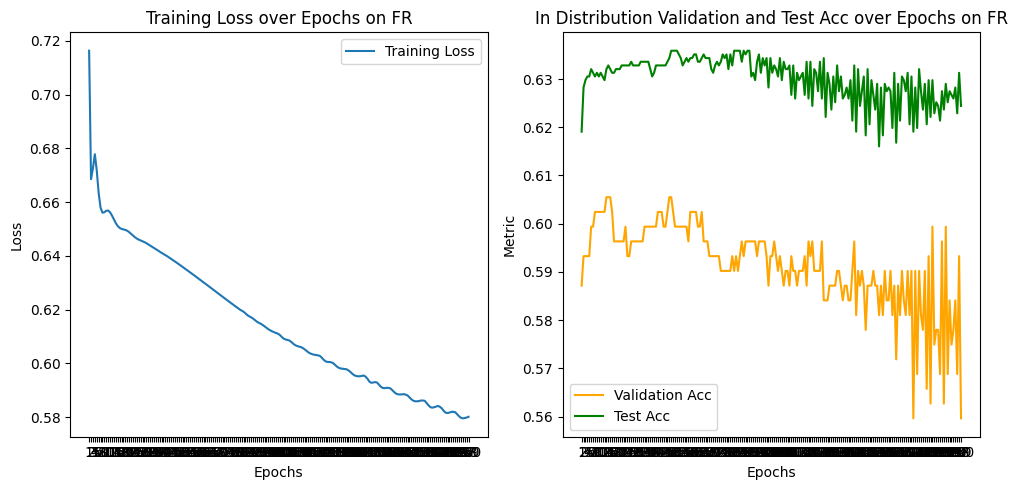

In [117]:
show_results('FR', ab_fr_res)
plot_curves(ab_fr_curves, 'FR')

In [118]:
ab_pt_res, ab_pt_model, ab_pt_curves = run_trials('PT', num_trials)

Epoch: 001, Test Acc: 0.6126
Epoch: 002, Test Acc: 0.6230
Epoch: 003, Test Acc: 0.6283
Epoch: 004, Test Acc: 0.6230
Epoch: 005, Test Acc: 0.6283
Epoch: 006, Test Acc: 0.6492
Epoch: 007, Test Acc: 0.6702
Epoch: 008, Test Acc: 0.6754
Epoch: 009, Test Acc: 0.6754
Epoch: 010, Test Acc: 0.6702
Epoch: 011, Test Acc: 0.6623
Epoch: 012, Test Acc: 0.6545
Epoch: 013, Test Acc: 0.6466
Epoch: 014, Test Acc: 0.6492
Epoch: 015, Test Acc: 0.6466
Epoch: 016, Test Acc: 0.6545
Epoch: 017, Test Acc: 0.6649
Epoch: 018, Test Acc: 0.6675
Epoch: 019, Test Acc: 0.6806
Epoch: 020, Test Acc: 0.6806
Epoch: 021, Test Acc: 0.6675
Epoch: 022, Test Acc: 0.6675
Epoch: 023, Test Acc: 0.6649
Epoch: 024, Test Acc: 0.6649
Epoch: 025, Test Acc: 0.6675
Epoch: 026, Test Acc: 0.6754
Epoch: 027, Test Acc: 0.6675
Epoch: 028, Test Acc: 0.6728
Epoch: 029, Test Acc: 0.6702
Epoch: 030, Test Acc: 0.6597
Epoch: 031, Test Acc: 0.6597
Epoch: 032, Test Acc: 0.6702
Epoch: 033, Test Acc: 0.6728
Epoch: 034, Test Acc: 0.6728
Epoch: 035, Te

Training on PT,
with out of distribution testing on DE: mean 0.5885553800245743, SE 0.022329721042165716
with out of distribution testing on EN: mean 0.48023391812865496, SE 0.009241986556789896
with out of distribution testing on ES: mean 0.689989235737352, SE 0.01852996244517454
with out of distribution testing on FR: mean 0.5804071246819339, SE 0.015904834532322536
with in of distribution testing on PT: mean 0.6823734729493892, SE 0.019667413035924345
with out of distribution testing on RU: mean 0.6377803116685671, SE 0.0304849809251624


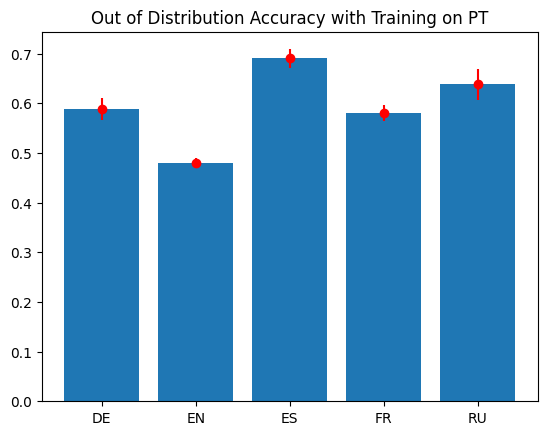

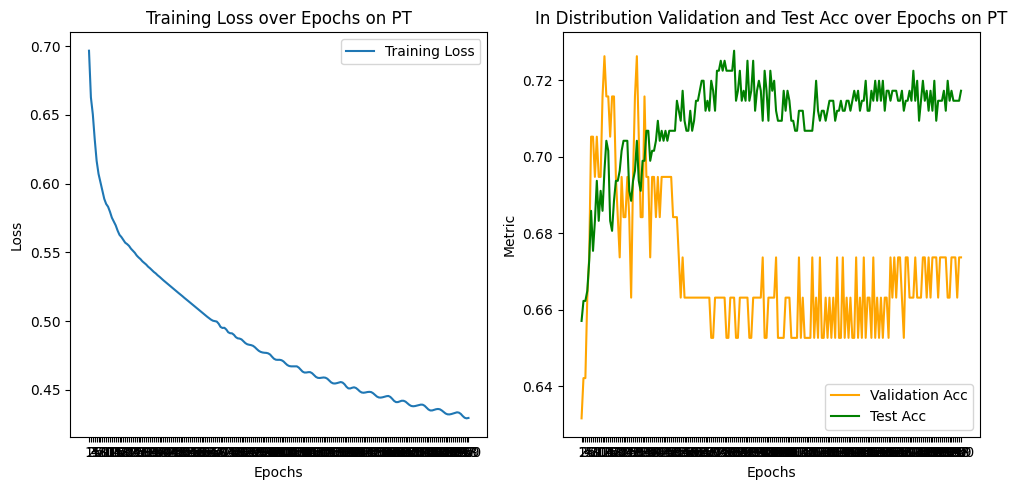

In [119]:
show_results('PT', ab_pt_res)
plot_curves(ab_pt_curves, 'PT')

In [120]:
ab_ru_res, ab_ru_model, ab_ru_curves = run_trials('RU', num_trials)

Epoch: 001, Test Acc: 0.7161
Epoch: 002, Test Acc: 0.7457
Epoch: 003, Test Acc: 0.7537
Epoch: 004, Test Acc: 0.7537
Epoch: 005, Test Acc: 0.7537
Epoch: 006, Test Acc: 0.7537
Epoch: 007, Test Acc: 0.7548
Epoch: 008, Test Acc: 0.7548
Epoch: 009, Test Acc: 0.7548
Epoch: 010, Test Acc: 0.7548
Epoch: 011, Test Acc: 0.7537
Epoch: 012, Test Acc: 0.7537
Epoch: 013, Test Acc: 0.7537
Epoch: 014, Test Acc: 0.7537
Epoch: 015, Test Acc: 0.7537
Epoch: 016, Test Acc: 0.7526
Epoch: 017, Test Acc: 0.7526
Epoch: 018, Test Acc: 0.7526
Epoch: 019, Test Acc: 0.7514
Epoch: 020, Test Acc: 0.7503
Epoch: 021, Test Acc: 0.7503
Epoch: 022, Test Acc: 0.7514
Epoch: 023, Test Acc: 0.7514
Epoch: 024, Test Acc: 0.7514
Epoch: 025, Test Acc: 0.7514
Epoch: 026, Test Acc: 0.7514
Epoch: 027, Test Acc: 0.7503
Epoch: 028, Test Acc: 0.7503
Epoch: 029, Test Acc: 0.7503
Epoch: 030, Test Acc: 0.7503
Epoch: 031, Test Acc: 0.7503
Epoch: 032, Test Acc: 0.7503
Epoch: 033, Test Acc: 0.7503
Epoch: 034, Test Acc: 0.7514
Epoch: 035, Te

Training on RU,
with out of distribution testing on DE: mean 0.47463577321397227, SE 0.0331395798494229
with out of distribution testing on EN: mean 0.46573099415204683, SE 0.009599197440319628
with out of distribution testing on ES: mean 0.6907068532472191, SE 0.0009493187337870499
with out of distribution testing on FR: mean 0.6190839694656488, SE 0.008018295804879755
with out of distribution testing on PT: mean 0.6527050610820244, SE 0.006815226593286782
with in of distribution testing on RU: mean 0.7198783732421132, SE 0.007714854857538744


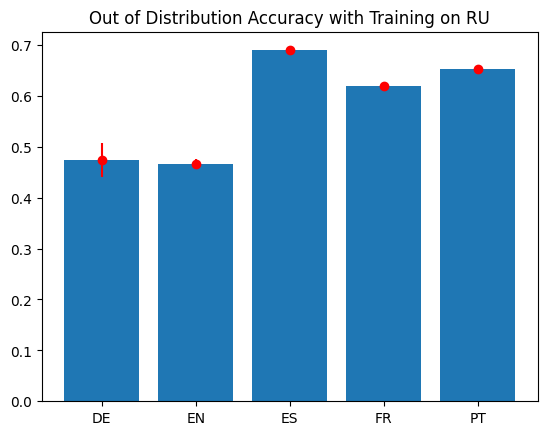

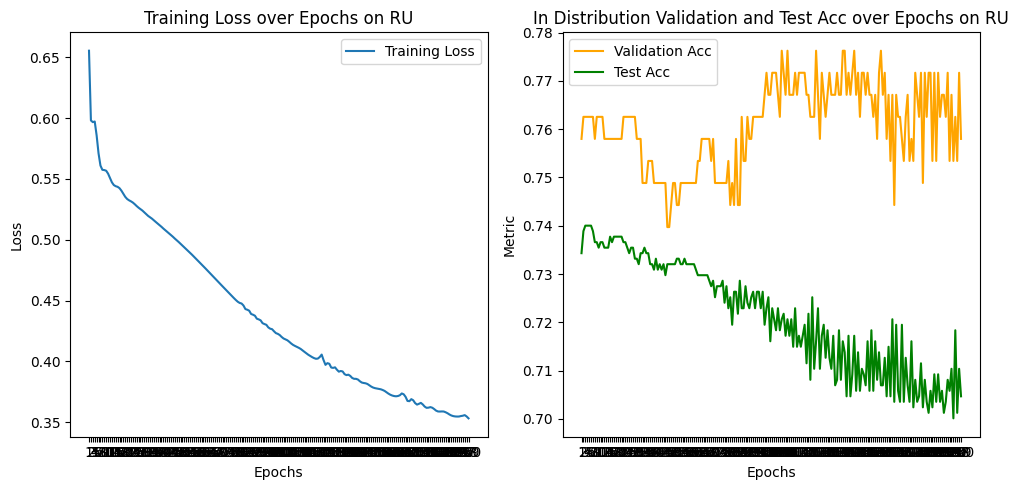

In [121]:
show_results('RU', ab_ru_res)
plot_curves(ab_ru_curves, 'RU')